## Download the dataset (title + abstract)

The titles are in the paper folder while the abstracts are in the abstract folder.


In [ ]:
import requests
import json
import os
import gzip
import pandas as pd

# Set your S2 API key
api_key = "09CuB8BwpZ8j8vzF3WtEK9aMSLHM98HM77BzJNym"

# Headers for authentication
headers = {
    "x-api-key": api_key
}

# Base output directory locally
base_output_dir = "./s2ag_dataset_title_abstracts"
os.makedirs(base_output_dir, exist_ok=True)


# Step 1: Get the latest release ID
latest_release_url = "https://api.semanticscholar.org/datasets/v1/release/latest"
response = requests.get(latest_release_url, headers=headers)
if response.status_code != 200:
    print(f"Failed to fetch latest release: {response.status_code} - {response.text}")
    exit()

latest_release = response.json()
release_id = latest_release["release_id"]
print("Latest release ID:", release_id)

# Step 2: Datasets to download
datasets = ["papers", "abstracts"]

# Dictionary to store data
data = {"title": [], "abstract": []}

for dataset_name in datasets:
    # Create dataset-specific directory
    output_dir = os.path.join(base_output_dir, dataset_name)
    os.makedirs(output_dir, exist_ok=True)

    # Step 3: Get metadata for the dataset
    dataset_url = f"https://api.semanticscholar.org/datasets/v1/release/{release_id}/dataset/{dataset_name}"
    response = requests.get(dataset_url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch metadata for {dataset_name}: {response.status_code} - {response.text}")
        continue

    dataset_info = response.json()
    print(f"\n{dataset_name.capitalize()} dataset metadata:")
    print(json.dumps(dataset_info, indent=2))

    # Step 4: Download all dataset files with simplified file names
    for index, file_url in enumerate(dataset_info["files"]):  # Process all files
        # Generate a shorter file name (e.g., papers_0.gz, abstracts_1.gz)
        file_name = f"{dataset_name}_{index}.gz"
        output_path = os.path.join(output_dir, file_name)

        print(f"Downloading {dataset_name}/{file_name}...")
        file_response = requests.get(file_url, headers=headers, stream=True)

        if file_response.status_code == 200:
            with open(output_path, "wb") as f:
                for chunk in file_response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
            print(f"Saved {file_name} to {output_path}")
        else:
            print(f"Failed to download {file_name}: {file_response.status_code} - {file_response.text}")

# Step 5: Process the datasets to extract titles and abstracts for Computer Science papers
print("\nProcessing datasets to extract titles and abstracts for Computer Science papers...")

# Dictionary to store titles and abstracts by corpusid
title_dict = {}
abstract_dict = {}

# Process papers dataset (for titles and field of study)
papers_dir = os.path.join(base_output_dir, "papers")
if os.path.exists(papers_dir):
    for file_name in os.listdir(papers_dir):
        if file_name.endswith(".gz"):
            file_path = os.path.join(papers_dir, file_name)
            try:
                with gzip.open(file_path, "rt", encoding="utf-8") as f:
                    for line in f:
                        try:
                            record = json.loads(line.strip())
                            corpusid = record.get("corpusid")
                            title = record.get("title")
                            fields_of_study = record.get("fieldsOfStudy", [])
                            # Filter for Computer Science
                            if corpusid and title and "Computer Science" in fields_of_study:
                                title_dict[corpusid] = title
                        except json.JSONDecodeError as e:
                            print(f"Error decoding JSON in {file_name}: {e}")
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
else:
    print("Papers directory not found. Skipping paper processing.")

# Process abstracts dataset
abstracts_dir = os.path.join(base_output_dir, "abstracts")
if os.path.exists(abstracts_dir):
    for file_name in os.listdir(abstracts_dir):
        if file_name.endswith(".gz"):
            file_path = os.path.join(abstracts_dir, file_name)
            try:
                with gzip.open(file_path, "rt", encoding="utf-8") as f:
                    for line in f:
                        try:
                            record = json.loads(line.strip())
                            corpusid = record.get("corpusid")
                            abstract = record.get("abstract")
                            if corpusid and abstract:
                                abstract_dict[corpusid] = abstract
                        except json.JSONDecodeError as e:
                            print(f"Error decoding JSON in {file_name}: {e}")
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
else:
    print("Abstracts directory not found. Skipping abstract processing.")

# Step 6: Combine titles and abstracts by corpusid for Computer Science papers
for corpusid in title_dict:
    if corpusid in abstract_dict:
        data["title"].append(title_dict[corpusid])
        data["abstract"].append(abstract_dict[corpusid])

# Step 7: Create DataFrame and save to CSV
if data["title"]:
    df = pd.DataFrame(data)
    print("\nSample of DataFrame (Computer Science papers):")
    print(df.head())

    # Save DataFrame to CSV
    df.to_csv(csv_output_path, index=False, encoding="utf-8")
    print(f"\nSaved DataFrame to {csv_output_path}")
else:
    print("\nNo matching title and abstract pairs found for Computer Science papers. CSV not created.")

print("\nProcessing complete!")

## Combine the datasets and filter English Only papers

In [ ]:
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import os
import logging

# Setup logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

def is_english(text):
    """
    Detect if the text is in English using langdetect.
    """
    try:
        return detect(text.strip()) == 'en'
    except LangDetectException:
        return False

def combine_english_title_abstracts(titles_csv, abstracts_csv, output_csv):
    """
    Combine English title-abstract pairs from CSV files into a single output CSV,
    processing data in chunks to handle large datasets.
    """
    english_pairs = []
    chunk_size = 50000  # Adjust based on memory; process 10,000 rows at a time

    logger.info(f"Starting processing of {titles_csv} and {abstracts_csv}")
    for chunk_titles in pd.read_csv(titles_csv, usecols=[1], chunksize=chunk_size):
        # Align abstracts chunk by skipping rows and matching length
        start_row = chunk_titles.index[0]
        chunk_abstracts = pd.read_csv(abstracts_csv, usecols=[1], skiprows=range(1, start_row + 1), nrows=chunk_size).squeeze()
        min_len = min(len(chunk_titles), len(chunk_abstracts))
        titles = chunk_titles.iloc[:min_len].squeeze()
        abstracts = chunk_abstracts.iloc[:min_len]

        # Process each pair in the chunk
        for title, abstract in zip(titles, abstracts):
            if pd.notna(title) and pd.notna(abstract):
                if is_english(title) and is_english(abstract):
                    english_pairs.append({'title': title.strip(), 'abstract': abstract.strip()})

        logger.info(f"Processed chunk starting at row {start_row} with {min_len} pairs")

    # Write to CSV file
    if english_pairs:
        df_output = pd.DataFrame(english_pairs)
        df_output.to_csv(output_csv, index=False, encoding='utf-8')
        logger.info(f"English-only combined file written to: {output_csv}")
        print(f"English-only combined file written to: {output_csv}")
    else:
        logger.warning(f"No English entries found. No file written to: {output_csv}")
        print(f"No English entries found. No file written to: {output_csv}")

if __name__ == "__main__":
    # Example usage with file paths
    titles_csv = 's2ag_dataset_title_abstracts/output/papers_csv/papers_0.csv'
    abstracts_csv = 's2ag_dataset_title_abstracts/output/abstracts_csv/abstracts_0.csv'
    output_csv = 'paper_dataset/paper_dataset_v0.csv'

    # Validate input files exist
    if not (os.path.exists(titles_csv) and os.path.exists(abstracts_csv)):
        logger.error("One or both input CSV files not found")
        print("Error: One or both input CSV files not found")
    else:
        combine_english_title_abstracts(titles_csv, abstracts_csv, output_csv)

In [ ]:
# for to complete whole process, 10000 rows took 185,3 seconds

In [26]:
from gensim.models import KeyedVectors

# Load the trained model
model_path = '9M[256-10]_sg.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Test similarity for a sample word
test_word = 'learning'
if test_word in model:
    similar_words = model.most_similar(test_word, topn=10)
    print(f"\nSimilar words to '{test_word}':")
    for word, score in similar_words:
        print(f"{word}: {score:.4f}")
else:
    print(f"'{test_word}' not in vocabulary")


Similar words to 'learning':
training: 0.6438
top-down: 0.6193
learners: 0.6129
bottom-up: 0.5940
online_learning: 0.5940
collective: 0.5755
reinforcement_learning: 0.5545
dialogue: 0.5530
inference: 0.5528
action: 0.5433


In [28]:
#pip install matplotlib numpy scikit-learn


Similar words to 'ontology':
semantically: 0.8153
provenance: 0.8128
petri_nets: 0.8029
ontology-based: 0.7947
xml-based: 0.7939
domain_knowledge: 0.7807
ontologies: 0.7764
ontological: 0.7755
enriched: 0.7753
formal_semantics: 0.7752


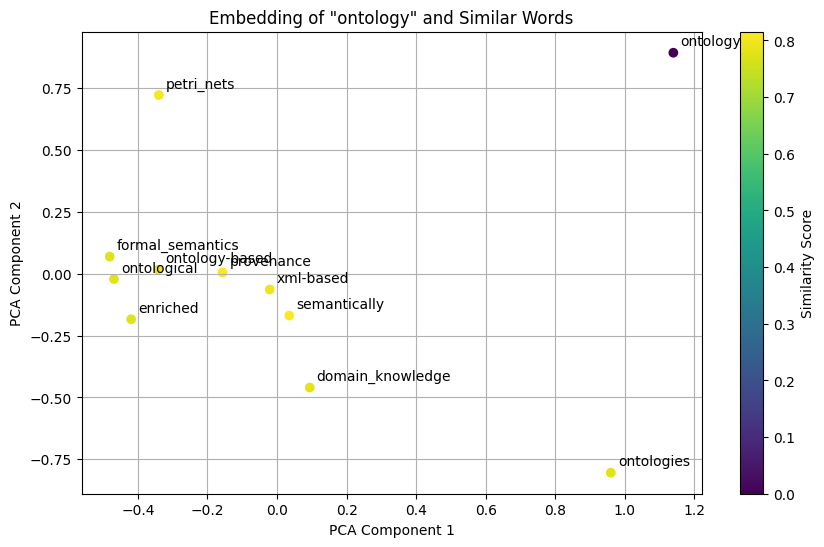

In [ ]:
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Load the trained model
model_path = '9M[256-10]_sg.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Test similarity for a sample word
test_word = 'semantic_web'
if test_word in model:
    similar_words = model.most_similar(test_word, topn=10)
    print(f"\nSimilar words to '{test_word}':")
    for word, score in similar_words:
        print(f"{word}: {score:.4f}")
    
    # Prepare data for visualization
    words = [test_word] + [word for word, _ in similar_words]
    word_vectors = np.array([model[word] for word in words])
    
    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_vectors)
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(result[:, 0], result[:, 1], c=[0] + [score for _, score in similar_words], cmap='viridis')
    
    # Annotate points with word labels
    for i, word in enumerate(words):
        plt.annotate(word, (result[i, 0], result[i, 1]), xytext=(5, 5), textcoords='offset points')
    
    # Add colorbar for similarity scores
    plt.colorbar(scatter, label='Similarity Score')
    plt.title(f'Embedding of "{test_word}" and Similar Words')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()
else:
    print(f"'{test_word}' not in vocabulary")